In [1]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

import gensim
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split , RandomizedSearchCV
import xgboost as xgb 

from scipy.fftpack import fft, ifft


from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler


from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import optuna

import sklearn.datasets

from collections import Counter

c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Record Constants
INPUT_TRAIN_IN = "../../data/train_in.csv"
INPUT_TRAIN_OUT = "../../data/train_out.csv"  
INPUT_TEST_IN = "../../data/test_in.csv"
INPUT_TEST_OUT = "../../data/test_out.csv"
INPUT_VALIDATION_IN = "../../data/valid_in_nucleo.csv"
INPUT_VALIDATION_OUT  = "../../data/valid_out.csv"

TARGET_MODEL_PATH = '../../webapp/model_files'


WINDOW_SIZE =  50 # Final RNA Sequence will be 101 Length 
MAX_LENGTH = (WINDOW_SIZE*2) +1


ENCODING_METHOD = 1

# 1 - XGBOOST 
MODEL = 1

FRAMEWORK = "PYTORCH"

INPUT_DIMENSION = 0

PERFORM_DATA_BALANCING = True
K_MERS_SIZE = 3


# Startegy to Crop Sequene
# MID - Modification is present at Mid of cropped Sequence 
# END - Modification is present at End of cropepd Sequence 
CROP_STRATEGY = 'END'


In [3]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1 )
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1 )

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1 )
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

x_valid_raw =  pd.read_csv(INPUT_VALIDATION_IN, header=None , skiprows=1 )
y_valid_raw =  pd.read_csv(INPUT_VALIDATION_OUT, header=None , skiprows=1 )

x_data = pd.concat([x_train_raw, x_test_raw, x_valid_raw], axis=0, ignore_index=True)
y_data = pd.concat([y_train_raw, y_test_raw, y_valid_raw], axis=0, ignore_index=True)

print(f"Train Shape of X : {x_train_raw.shape} and Tranin Shape of Y : {x_train_raw.shape}")
print(f"Test Shape of X : {x_test_raw.shape} and Test Shape of Y : {y_test_raw.shape}")
print(f"Validation Shape of X : {x_valid_raw.shape} and Validation Shape of Y : {y_valid_raw.shape}")


Train Shape of X : (304661, 1001) and Tranin Shape of Y : (304661, 1001)
Test Shape of X : (1200, 1001) and Test Shape of Y : (1200, 12)
Validation Shape of X : (3599, 1001) and Validation Shape of Y : (3599, 12)


### Calculate Sequence Positions to extracted from Original Sequence 

In [4]:
middle_index = (x_train_raw.shape[1] // 2) + 1

if CROP_STRATEGY == 'MID':
    STRAT_INEDX =middle_index - WINDOW_SIZE -1 
    END_INDEX =middle_index + WINDOW_SIZE 

if CROP_STRATEGY == 'END':
    STRAT_INEDX =middle_index - (WINDOW_SIZE*2) -1 
    END_INDEX =middle_index


### Apply One Hot Encoding

In [5]:
number_of_unique_kmers = set()
def encode_seq(kmer_token):

    # A 1 0 0 0
    # C 0 1 0 0
    # T/U 0 0 0 1
    # G 0 0 1 0
    # N 0 0 0 0

    encoding_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [0, 0, 0, 1],
        'N': [0, 0, 0, 0],
    }

    encoded_sequence = []
    number_of_unique_kmers.add(kmer_token)
    for  base in kmer_token:
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).flatten()

def applyOneHotEncoding(tokenized_sequences):
    encoded_sequences = []
    for seq in tokenized_sequences:
        encoded_sequences.append(encode_seq(seq)) 
 
    return np.array(encoded_sequences).flatten()

def encode_with_one_hot_encoding(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    concatenated_column= truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    df_result = truncated_df.assign(Sequence=concatenated_column)
    tokenized_sequences =  df_result['Sequence'].apply(applyOneHotEncoding).tolist()
    
    return tokenized_sequences


In [6]:
## Filter Dataset to Keep only Target Binary Class 

RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [12,1,2,3,4,5,6,7,8,9,10,11,0]

ARMs = ['hm6A', 'hm1A' , 'hAm' , 'Atol' , 'hm6Am']
ARMEncoding = [0,1,2,3,4]

def convert_y_to_original_labels(row):
    label = ""
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            label = RMs[index]
    if label == '':
        return 'NonMoD'
    return label

def get_original_y_lables( y_data ):
    # Convert One Hot Encoded Y to to Original Labels 
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    return y_original_labels  



def encode_target(y_data):
    # Write Customer Lable Encoder . This is required since we have train and test alreday splitted. Always creating a new instanc of label encoder will change encoding.

    y_encoded = []
    for y in y_data:
        index = ARMs.index(y)
        encoding =  ARMEncoding[index]
        y_encoded.append(encoding)
    return y_encoded

def prepare_data_for_binary_classification(x_data , y_data , prediction_class):
    # Convert One Hot Encoded Y to to Original Labels 
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    x_data['Label'] = y_original_labels
    target_class = prediction_class   
    selected_rna_data = x_data[x_data['Label'].isin(target_class)] 

    y_filtered = selected_rna_data['Label']
    x_filtered = selected_rna_data.drop('Label', axis=1)

    return x_filtered , y_filtered 

In [7]:
class_A_list = ['hm6A', 'hm1A' , 'hAm' , 'Atol' , 'hm6Am']

x_data_filtered , y_data_filtered = prepare_data_for_binary_classification(x_data , y_data , class_A_list)
x_encoded = encode_with_one_hot_encoding(x_data_filtered) 
y_encoded = encode_target(y_data_filtered)

# Train set
X_train, X_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size=0.3, random_state=42)

# x_train_filtered , y_train_filtered  =  prepare_data_for_binary_classification(x_train_raw , y_train_raw , class_A_list)
# x_test_filtered  ,  y_test_filtered =  prepare_data_for_binary_classification(x_test_raw , y_test_raw , class_A_list)
# x_valid_filtered ,  y_valid_filtered =  prepare_data_for_binary_classification(x_valid_raw , y_valid_raw , class_A_list)


# X_train = encode_with_one_hot_encoding(x_train_filtered) 
# X_test = encode_with_one_hot_encoding(x_test_filtered)
# X_valid = encode_with_one_hot_encoding(x_valid_filtered) 

# # Filter out Class A Type Nucloeside 

# y_train = encode_target(y_train_filtered)
# y_test = encode_target(y_test_filtered)
# y_valid = encode_target(y_valid_filtered)

In [8]:
print("Train Y Count : " ,Counter(y_train))
print("Test Y Count : " ,Counter(y_test))


Train Y Count :  Counter({0: 45515, 3: 36874, 1: 11487, 4: 1757, 2: 1089})
Test Y Count :  Counter({0: 19663, 3: 15744, 1: 4854, 4: 690, 2: 502})


### Apply Word2Vec Model

In [9]:
# Model Documentation - 
# Encode RNA sequences using Word2Vec embeddings
def encode_sequence(sequence , word2vec_model):
    embeddings = []
    for kmer in sequence:
        embeddings.append(word2vec_model.wv[kmer])
    return np.mean(embeddings, axis=0)

def applyKmersAndEncoding(seq):
    k = 3
    tokenized_sequences = [''.join(seq[i:i+k]) for i in range(0, len(seq)-k+1)]
    return tokenized_sequences
    


def encode_x_with_word2Vec(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    tokenized_sequences =  truncated_df['Sequence'].apply(applyKmersAndEncoding).tolist()
    
    # The result, tokenized_sequences, is a list of lists, where each inner list
    #  contains the k-mers of the corresponding RNA sequence from the truncated_df list. 
    embedding_size = 100
    word2vec_model = gensim.models.Word2Vec(tokenized_sequences, vector_size=embedding_size, window=5, min_count=1, workers=4)

    result = []
    for seq in tokenized_sequences:
        embedding = encode_sequence(seq , word2vec_model)
        result.append(embedding)
    return result 


### Re-Sample Data Using RandomOverSampler

In [10]:

sm = RandomOverSampler(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled


counts = Counter(y_resampled)
print(counts)


Counter({0: 45515, 3: 45515, 1: 45515, 2: 45515, 4: 45515})


### Train using XGBoost 

In [11]:
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 4,
    'n_jobs': -1,
    'enable_categorical': True
}

dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
num_rounds = 100 
model = xgb.train(params, dtrain, num_rounds)     


[20:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "enable_categorical" } are not used.



### XGBoost Test and Accuracy

Test Accuracy: 0.57
Accuracy of XGBoost  model: 0.57


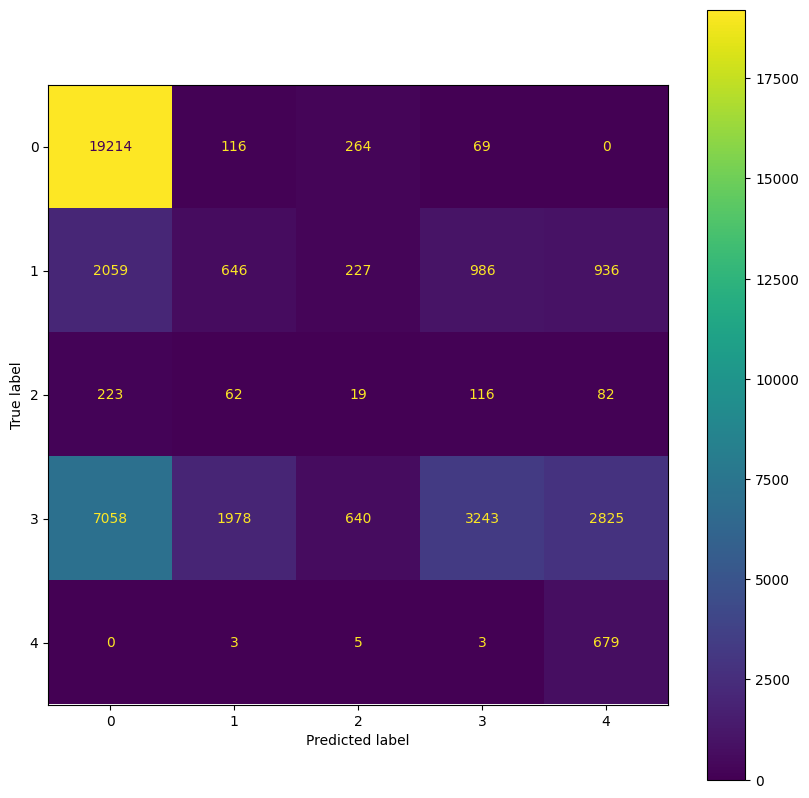

In [12]:
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest) 
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=np.array(ARMEncoding))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=np.array(ARMEncoding))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

### XgBoost with Hyper Paramter Tuning - RandomizedSearchCV

In [13]:
# if MODEL == 2:
#     # Create the XGBoost classifier
#     xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=13, random_state=42)

#     # Define the hyperparameter search space
#     param_dist = {
#         'learning_rate': [0.1, 0.01, 0.001],
#         'max_depth': [3, 5, 7, 10],
#         'min_child_weight':   [1, 3, 5],
#         'subsample': [0.5, 0.75, 1],
#         'colsample_bytree': [0.5, 0.75, 1],
#         'n_estimators': [100, 250, 500]
#     }

#     # Create the RandomizedSearchCV object
#     random_search = RandomizedSearchCV(xgb_clf, param_dist, cv=3, n_iter=20, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

#     # Perform the randomized search
#     random_search.fit(X_train, y_train)

#     # Get the best hyperparameters
#     best_params = random_search.best_params_
#     print("Best hyperparameters:\n", best_params)

#     # Train the classifier with the best hyperparameters
#     best_xgb_clf = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=13, random_state=42)
#     best_xgb_clf.fit(X_train, y_train)

#     # Make predictions on the test set
#     y_pred = best_xgb_clf.predict(X_test)

#     # Evaluate the model
#     print("Accuracy:", accuracy_score(y_test, y_pred))
#     print("\nClassification report:\n", classification_report(y_test, y_pred))

### XgBoost with Hyper Paramter Tuning - GridSearchCV

In [14]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report

# if MODEL == 3:
#     # Create the XGBoost classifier
#     xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=13, random_state=42 )

#     # Define the hyperparameter search space
#     param_grid = {
#         'learning_rate': [0.1, 0.01, 0.001],
#         'max_depth': [3, 5, 7, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.75, 1],
#         'colsample_bytree': [0.5, 0.75, 1],
#         'n_estimators': [100, 250, 500]
#     }

#     # Create the GridSearchCV object
#     grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

#     # Perform the grid search
#     grid_search.fit(X_train, y_train)

#     # Get the best hyperparameters
#     best_params = grid_search.best_params_
#     print("Best hyperparameters:\n", best_params)

#     # Train the classifier with the best hyperparameters
#     best_xgb_clf = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=13, random_state=42)
#     best_xgb_clf.fit(X_train, y_train)

#     # Make predictions on the test set
#     y_pred = best_xgb_clf.predict(X_test)

#     # Evaluate the model
#     print("Accuracy:", accuracy_score(y_test, y_pred))
#     print("\nClassification report:\n", classification_report(y_test, y_pred))

### Optimization with Optuna With XgBoost

In [15]:
# def objective(trial):
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dvalid = xgb.DMatrix(X_test, label=y_test)

#     param = {
#         "verbosity": 0,
#         "objective": "multi:softmax",
#         "num_class": 5 ,
#         # defines booster, gblinear for linear functions.
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         # L2 regularization weight.
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         # L1 regularization weight.
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         # sampling ratio for training data.
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         # sampling according to each tree.
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         # maximum depth of the tree, signifies complexity of the tree.
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         # minimum child weight, larger the term more conservative the tree.
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         # defines how selective algorithm is.
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

#     num_rounds = 100 
#     bst = xgb.train(param, dtrain , num_rounds )
#     preds = bst.predict(dvalid)
#     pred_labels = np.rint(preds)
#     accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
#     return accuracy


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, timeout=6000)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

# # Number of finished trials:  76
# # Best trial:
# #   Value: 0.6052047652900752
# #   Params: 
# #     booster: gblinear
# #     lambda: 3.0789981964094497e-06
# #     alpha: 2.468290506036041e-06
# #     subsample: 0.8524524714955344
# #     colsample_bytree: 0.498783948236617

In [17]:
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
import optuna

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "num_class": 5 ,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "eval_metric": "mlogloss"
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-mlogloss")
    bst = xgb.train(param, dtrain, num_boost_round=500, evals=[(dvalid, "test")], early_stopping_rounds=10, callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=6000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Could Achieve upto 67 % - Train on GPU now for faster parameter evaluation.


[I 2023-06-03 20:15:12,096] A new study created in memory with name: no-name-a736f11a-9e10-449e-8629-84a8f921455c


[0]	test-mlogloss:1.26650
[1]	test-mlogloss:1.16629
[2]	test-mlogloss:1.11923
[3]	test-mlogloss:1.08957
[4]	test-mlogloss:1.06919
[5]	test-mlogloss:1.05523
[6]	test-mlogloss:1.04531
[7]	test-mlogloss:1.03851
[8]	test-mlogloss:1.03398
[9]	test-mlogloss:1.03100
[10]	test-mlogloss:1.02908
[11]	test-mlogloss:1.02785
[12]	test-mlogloss:1.02709
[13]	test-mlogloss:1.02663
[14]	test-mlogloss:1.02637
[15]	test-mlogloss:1.02622
[16]	test-mlogloss:1.02616
[17]	test-mlogloss:1.02615
[18]	test-mlogloss:1.02617
[19]	test-mlogloss:1.02622
[20]	test-mlogloss:1.02627
[21]	test-mlogloss:1.02634
[22]	test-mlogloss:1.02641
[23]	test-mlogloss:1.02649
[24]	test-mlogloss:1.02656
[25]	test-mlogloss:1.02664
[26]	test-mlogloss:1.02672
[27]	test-mlogloss:1.02680


[I 2023-06-03 20:15:16,351] Trial 0 finished with value: 0.6535594528743396 and parameters: {'booster': 'gblinear', 'lambda': 4.684622439453853e-08, 'alpha': 0.047706959155110744, 'subsample': 0.20811943489142903, 'colsample_bytree': 0.8533403688192887}. Best is trial 0 with value: 0.6535594528743396.


[0]	test-mlogloss:1.07994
[1]	test-mlogloss:0.97214
[2]	test-mlogloss:0.92508
[3]	test-mlogloss:0.90025
[4]	test-mlogloss:0.88562
[5]	test-mlogloss:0.87654
[6]	test-mlogloss:0.87022
[7]	test-mlogloss:0.86574
[8]	test-mlogloss:0.86242
[9]	test-mlogloss:0.86004
[10]	test-mlogloss:0.85830
[11]	test-mlogloss:0.85704
[12]	test-mlogloss:0.85616
[13]	test-mlogloss:0.85543
[14]	test-mlogloss:0.85484
[15]	test-mlogloss:0.85433
[16]	test-mlogloss:0.85385
[17]	test-mlogloss:0.85333
[18]	test-mlogloss:0.85298
[19]	test-mlogloss:0.85266
[20]	test-mlogloss:0.85235
[21]	test-mlogloss:0.85215
[22]	test-mlogloss:0.85202
[23]	test-mlogloss:0.85188
[24]	test-mlogloss:0.85177
[25]	test-mlogloss:0.85168
[26]	test-mlogloss:0.85164
[27]	test-mlogloss:0.85162
[28]	test-mlogloss:0.85161
[29]	test-mlogloss:0.85159
[30]	test-mlogloss:0.85156
[31]	test-mlogloss:0.85151
[32]	test-mlogloss:0.85145
[33]	test-mlogloss:0.85140
[34]	test-mlogloss:0.85136
[35]	test-mlogloss:0.85132
[36]	test-mlogloss:0.85130
[37]	test-m

[I 2023-06-03 20:17:08,465] Trial 1 finished with value: 0.6780208911297132 and parameters: {'booster': 'gblinear', 'lambda': 0.0001524095707409649, 'alpha': 0.00430434710449382, 'subsample': 0.7713420630609624, 'colsample_bytree': 0.3014082554623869}. Best is trial 1 with value: 0.6780208911297132.


[0]	test-mlogloss:1.11512
[1]	test-mlogloss:0.97697
[2]	test-mlogloss:0.91864
[3]	test-mlogloss:0.88805
[4]	test-mlogloss:0.86921
[5]	test-mlogloss:0.85735
[6]	test-mlogloss:0.84900
[7]	test-mlogloss:0.84304
[8]	test-mlogloss:0.83883
[9]	test-mlogloss:0.83582
[10]	test-mlogloss:0.83346
[11]	test-mlogloss:0.83160
[12]	test-mlogloss:0.83022
[13]	test-mlogloss:0.82928
[14]	test-mlogloss:0.82852
[15]	test-mlogloss:0.82793
[16]	test-mlogloss:0.82749
[17]	test-mlogloss:0.82716
[18]	test-mlogloss:0.82691
[19]	test-mlogloss:0.82672
[20]	test-mlogloss:0.82657
[21]	test-mlogloss:0.82645
[22]	test-mlogloss:0.82636
[23]	test-mlogloss:0.82629
[24]	test-mlogloss:0.82623
[25]	test-mlogloss:0.82616
[26]	test-mlogloss:0.82612
[27]	test-mlogloss:0.82606
[28]	test-mlogloss:0.82605
[29]	test-mlogloss:0.82603
[30]	test-mlogloss:0.82599
[31]	test-mlogloss:0.82599
[32]	test-mlogloss:0.82599
[33]	test-mlogloss:0.82599
[34]	test-mlogloss:0.82596
[35]	test-mlogloss:0.82596
[36]	test-mlogloss:0.82594
[37]	test-m

[I 2023-06-03 20:17:59,804] Trial 2 finished with value: 0.6780208911297132 and parameters: {'booster': 'gblinear', 'lambda': 1.1062942649886671e-05, 'alpha': 0.00041830641999053884, 'subsample': 0.9040931802879215, 'colsample_bytree': 0.9179461959761883}. Best is trial 1 with value: 0.6780208911297132.


[0]	test-mlogloss:1.60942
[1]	test-mlogloss:1.60941
[2]	test-mlogloss:1.60939
[3]	test-mlogloss:1.60938
[4]	test-mlogloss:1.60936
[5]	test-mlogloss:1.60934
[6]	test-mlogloss:1.60933
[7]	test-mlogloss:1.60932
[8]	test-mlogloss:1.60930
[9]	test-mlogloss:1.60929
[10]	test-mlogloss:1.60927
[11]	test-mlogloss:1.60925
[12]	test-mlogloss:1.60924
[13]	test-mlogloss:1.60922
[14]	test-mlogloss:1.60921
[15]	test-mlogloss:1.60920
[16]	test-mlogloss:1.60918
[17]	test-mlogloss:1.60917
[18]	test-mlogloss:1.60915
[19]	test-mlogloss:1.60914
[20]	test-mlogloss:1.60912
[21]	test-mlogloss:1.60911
[22]	test-mlogloss:1.60909
[23]	test-mlogloss:1.60908
[24]	test-mlogloss:1.60906
[25]	test-mlogloss:1.60905
[26]	test-mlogloss:1.60903
[27]	test-mlogloss:1.60902
[28]	test-mlogloss:1.60900
[29]	test-mlogloss:1.60898
[30]	test-mlogloss:1.60897
[31]	test-mlogloss:1.60896
[32]	test-mlogloss:1.60895
[33]	test-mlogloss:1.60893
[34]	test-mlogloss:1.60892
[35]	test-mlogloss:1.60890
[36]	test-mlogloss:1.60889
[37]	test-m

## Save Model 

In [ ]:
# import pickle

# TARGET_MODEL_PATH += '/xgboost_model.bin'

# ##dump the model into a file
# with open(TARGET_MODEL_PATH, 'wb') as f_out:
#     pickle.dump(bst, f_out) # write final_model in .bin file
#     f_out.close()  # close the file 
#     print("Exported Model Successfully")  